<a href="https://colab.research.google.com/github/MdShakil-Hossain/366-Final-Lab/blob/main/CSE_366_Final_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install torch torchvision matplotlib grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=0571329633c34dd873f6bc96239d9b0416f2a362938acf54e06ec49c35771192
  Stored in directory: /root/.cache/pip/wheels/8b/0d/d2/b12bec1ccc028921fb98158042ade2d19dae73925dfc636954
Successfully built grad-cam


In [11]:
#Mounting
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#Path_to_dataset
dataset_path = '/content/drive/MyDrive/CSE 366 Lab/caltech-101'

In [6]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [23]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [40]:
#Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

#Number of classes
num_classes = len(dataset.classes)
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 102


In [41]:
#Split dataset into training, validation and testing sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [42]:
#DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [43]:
#Using ResNet50 as the pre-trained model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, num_classes)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 3.5704
Epoch 2, Loss: 2.7344
Epoch 3, Loss: 2.3662
Epoch 4, Loss: 2.0330
Epoch 5, Loss: 1.7701
Epoch 6, Loss: 1.5812
Epoch 7, Loss: 1.4904
Epoch 8, Loss: 1.3383
Epoch 9, Loss: 1.2293
Epoch 10, Loss: 1.1270


In [44]:
model.eval()
val_accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_accuracy += (preds == labels).sum().item()
val_accuracy /= len(val_data)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Validation Accuracy: 1.31%


In [45]:
test_accuracy = 0
y_pred, y_true = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_accuracy += (preds == labels).sum().item()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

test_accuracy /= len(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 0.55%


In [46]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

report = classification_report(y_true, y_pred, target_names=dataset.classes)
print("Classification Report:\n", report)

Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report:
                    precision    recall  f1-score   support

BACKGROUND_Google       1.00      0.02      0.05        41
            Faces       0.00      0.00      0.00        34
       Faces_easy       0.00      0.00      0.00        38
         Leopards       0.00      0.00      0.00        24
       Motorbikes       0.00      0.00      0.00        78
        accordion       0.00      0.00      0.00         7
        airplanes       0.00      0.00      0.00        83
           anchor       0.00      0.00      0.00         6
              ant       0.00      0.00      0.00         5
           barrel       0.00      0.00      0.00         6
             bass       0.00      0.00      0.00         8
           beaver       0.00      0.00      0.00         5
        binocular       0.00      0.00      0.00         5
          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
!pip install --upgrade grad-cam

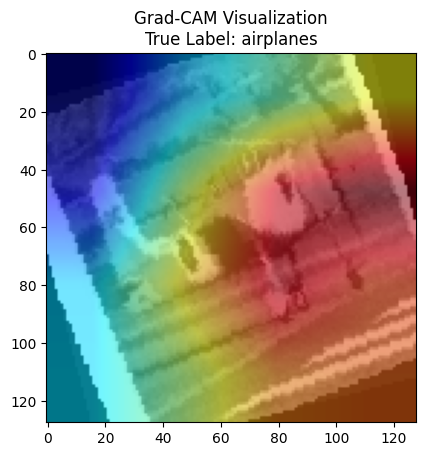

In [55]:
#The targeted layer
target_layers = [model.layer4[-1]]  # Last convolutional layer in ResNet50

#Initializing Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers)

#Displaying Grad-CAM for the first test image
for images, labels in test_loader:
    #Grad-CAM heatmap
    grayscale_cam = cam(input_tensor=images)

    #Converting the image to NumPy and normalize to [0, 1]
    input_image = images[0].permute(1, 2, 0).cpu().numpy()  # Shape: H x W x C
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())

    #Visualizing Grad-CAM on the normalized input image
    cam_image = show_cam_on_image(input_image, grayscale_cam[0], use_rgb=True)

    #Ploting the image with Grad-CAM overlay
    plt.imshow(cam_image)
    plt.title(f"Grad-CAM Visualization\nTrue Label: {dataset.classes[labels[0]]}")
    plt.show()
    break


In [56]:
torch.save(model.state_dict(), "caltech101_resnet50.pth")

In [ ]:
#Path_to_dataset
dataset_path = '/content/drive/MyDrive/CSE 366 Lab/caltech-101'
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

#Number of classes
num_classes = len(dataset.classes)
print(f"Number of classes in the dataset: {num_classes}")

#Split dataset into training, validation and testing sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

#DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

from torchvision.models import vgg19

model = vgg19(pretrained=True)
model.classifier[6] = nn.Linear(4096, num_classes)  # Adjust the final layer for 101 classes

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

model.eval()
val_accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_accuracy += (preds == labels).sum().item()
val_accuracy /= len(val_data)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

test_accuracy = 0
y_pred, y_true = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_accuracy += (preds == labels).sum().item()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

test_accuracy /= len(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

report = classification_report(y_true, y_pred, target_names=dataset.classes)
print("Classification Report:\n", report)

Number of classes in the dataset: 102


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 4.5939
Epoch 2, Loss: 4.2102
Epoch 3, Loss: 4.2031


In [10]:
#Path_to_dataset
dataset_path = '/content/drive/MyDrive/CSE 366 Lab/caltech-101'

import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

#Number of classes
num_classes = len(dataset.classes)
print(f"Number of classes in the dataset: {num_classes}")

#Split dataset into training, validation and testing sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

#DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(1280, num_classes)  # Adjust the final layer for 101 classes

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

model.eval()
val_accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_accuracy += (preds == labels).sum().item()
val_accuracy /= len(val_data)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

test_accuracy = 0
y_pred, y_true = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_accuracy += (preds == labels).sum().item()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

test_accuracy /= len(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

report = classification_report(y_true, y_pred, target_names=dataset.classes)
print("Classification Report:\n", report)

Number of classes in the dataset: 102


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 36.6MB/s]


Epoch 1, Loss: 2.1823
Epoch 2, Loss: 1.1245
Epoch 3, Loss: 0.8788
Epoch 4, Loss: 0.6980
Epoch 5, Loss: 0.6013
Epoch 6, Loss: 0.5372
Epoch 7, Loss: 0.4600
Epoch 8, Loss: 0.4390
Epoch 9, Loss: 0.4412
Epoch 10, Loss: 0.3842
Validation Accuracy: 77.24%
Test Accuracy: 84.04%
Confusion Matrix:
 [[29  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 44 ...  0  0  0]
 ...
 [ 1  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0 10]]
Classification Report:
                    precision    recall  f1-score   support

BACKGROUND_Google       0.63      0.63      0.63        46
            Faces       1.00      1.00      1.00        30
       Faces_easy       1.00      1.00      1.00        44
         Leopards       0.89      1.00      0.94        24
       Motorbikes       1.00      0.98      0.99        85
        accordion       1.00      1.00      1.00         6
        airplanes       0.94      0.97      0.96        80
           anchor       0.75      0.75      0.75         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
